In [3]:
import altair as alt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import xgboost as xg
from sklearn.metrics import *

In [130]:
def getThreshold(y_test, probs, pos_label):
    probs = probs.T[1]
    actual = np.array([y_test == pos_label]).astype(int)[0]
    resultsdf = pd.DataFrame(data = {'Actual':actual, 'Probability':probs})
    tplist = []
    tnlist = []
    fplist = []
    fnlist = []
    threshlist = []
    for thresh in np.linspace(0,1,num=51):
        y_pred = probs > thresh
        tplist.append((resultsdf['Actual'] * y_pred).sum())
        tnlist.append(((1 - resultsdf['Actual']) * (1 - y_pred)).sum())
        fplist.append(((1 - resultsdf['Actual']) * y_pred).sum())
        fnlist.append((resultsdf['Actual'] * (1 - y_pred)).sum())
        threshlist.append(thresh)
    accdf = pd.DataFrame(data = {'Threshold':threshlist, 'TP':tplist, 'TN':tnlist, 'FP':fplist, 'FN':fnlist})
    accdf['Accuracy'] = (accdf['TP'] + accdf['TN']) / (accdf['TP'] + accdf['FP'] + accdf['TN'] + accdf['FN'])
    accdf['Precision'] = accdf['TP'] / (accdf['TP'] + accdf['FP'])
    accdf['Recall / Sensitivity'] = accdf['TP'] / (accdf['TP'] + accdf['FN'])
    accdf['Specificity'] = accdf['TN'] / (accdf['TN'] + accdf['TP'])
    accdf['F1'] = 2*((accdf['Precision'] * accdf['Recall / Sensitivity']) / (accdf['Precision'] + accdf['Recall / Sensitivity']))
    accdf['FN_Cost'] = accdf['FN']*500
    accdf['FP_Cost'] = accdf['FP']*10
    accdf['Tot_Cost'] = accdf['FN_Cost']+accdf['FP_Cost']
    accdf['Cost_per_Obs'] = accdf['Tot_Cost']/(accdf['TP']+accdf['TN']+accdf['FP']+accdf['FN'])
    return accdf

In [5]:
#load csv
file_path = "C:\\Users\\blgai\\OneDrive\\Documents\\School\\SMU\\Courses\\Spring 2021\\Quantifying The World\\Case Study 14\\Data\\final_project.csv"
#load Data into Pandas
df_full = pd.read_csv(file_path)

In [6]:
df_full.head(5)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
0,-0.166563,-3.961588,4.621113,2.481908,-1.800135,0.804684,6.718751,-14.789997,-1.040673,-4.204950,...,-1.497117,5.414063,-2.325655,1.674827,-0.264332,60.781427,-7.689696,0.151589,-8.040166,0
1,-0.149894,-0.585676,27.839856,4.152333,6.426802,-2.426943,40.477058,-6.725709,0.896421,0.330165,...,36.292790,4.490915,0.762561,6.526662,1.007927,15.805696,-4.896678,-0.320283,16.719974,0
2,-0.321707,-1.429819,12.251561,6.586874,-5.304647,-11.311090,17.812850,11.060572,5.325880,-2.632984,...,-0.368491,9.088864,-0.689886,-2.731118,0.754200,30.856417,-7.428573,-2.090804,-7.869421,0
3,-0.245594,5.076677,-24.149632,3.637307,6.505811,2.290224,-35.111751,-18.913592,-0.337041,-5.568076,...,15.691546,-7.467775,2.940789,-6.424112,0.419776,-72.424569,5.361375,1.806070,-7.670847,0
4,-0.273366,0.306326,-11.352593,1.676758,2.928441,-0.616824,-16.505817,27.532281,1.199715,-4.309105,...,-13.911297,-5.229937,1.783928,3.957801,-0.096988,-14.085435,-0.208351,-0.894942,15.724742,1


In [8]:
df_full.shape

(160000, 51)

In [9]:
#Let's check to see how many data points are missing by attribute
len(df_full)-df_full.count()

x0     26
x1     25
x2     38
x3     37
x4     26
x5     37
x6     26
x7     27
x8     21
x9     30
x10    43
x11    30
x12    36
x13    31
x14    34
x15    35
x16    26
x17    27
x18    40
x19    35
x20    38
x21    29
x22    27
x23    47
x24    28
x25    22
x26    36
x27    30
x28    35
x29    30
x30    30
x31    39
x32    31
x33    41
x34    41
x35    30
x36    27
x37    23
x38    31
x39    23
x40    36
x41    40
x42    26
x43    37
x44    40
x45    29
x46    31
x47    37
x48    32
x49    32
y       0
dtype: int64

In [10]:
#let's check the 5 number summary of the data
df_full.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
count,159974.000000,159975.000000,159962.000000,159963.000000,159974.000000,159963.000000,159974.000000,159973.000000,159979.000000,159970.000000,...,159960.000000,159974.000000,159963.000000,159960.000000,159971.000000,159969.000000,159963.000000,159968.000000,159968.000000,160000.000000
mean,-0.001028,0.001358,-1.150145,-0.024637,-0.000549,0.013582,-1.670670,-7.692795,-0.030540,0.005462,...,6.701076,-1.833820,-0.002091,-0.006250,0.000885,-12.755395,0.028622,-0.000224,-0.674224,0.401231
std,0.371137,6.340632,13.273480,8.065032,6.382293,7.670076,19.298665,30.542264,8.901185,6.355040,...,18.680196,5.110705,1.534952,4.164595,0.396621,36.608641,4.788157,1.935501,15.036738,0.490149
min,-1.592635,-26.278302,-59.394048,-35.476594,-28.467536,-33.822988,-86.354483,-181.506976,-37.691045,-27.980659,...,-82.167224,-27.933750,-6.876234,-17.983487,-1.753221,-201.826828,-21.086333,-8.490155,-65.791191,0.000000
25%,-0.251641,-4.260973,-10.166536,-5.454438,-4.313118,-5.148130,-14.780146,-27.324771,-6.031058,-4.260619,...,-5.804080,-5.162869,-1.039677,-2.812055,-0.266518,-36.428329,-3.216016,-1.320800,-10.931753,0.000000
50%,-0.002047,0.004813,-1.340932,-0.031408,0.000857,0.014118,-1.948594,-6.956789,-0.016840,0.006045,...,6.840110,-1.923754,-0.004385,-0.010484,0.001645,-12.982497,0.035865,-0.011993,-0.574410,0.000000
75%,0.248532,4.284220,7.871676,5.445179,4.306660,5.190749,11.446931,12.217071,5.972349,4.305734,...,19.266367,1.453507,1.033275,2.783274,0.269049,11.445443,3.268028,1.317703,9.651072,1.000000
max,1.600849,27.988178,63.545653,38.906025,26.247812,35.550110,92.390605,149.150634,39.049831,27.377842,...,100.050432,22.668041,6.680922,19.069759,1.669205,150.859415,20.836854,8.226552,66.877604,1.000000


In [11]:
#let's drop records containing missing values
df_full = df_full.dropna()

In [12]:
#after dropping records with missing data we end up with 158392 records out of 160000
df_full.shape

(158392, 51)

In [16]:
#we still have 98.99% of the data, only removing 1.1% of the data with missing values
len(df_full)/160000

0.98995

In [39]:
# we can see that there are categorical variables
df_full.dtypes

x0     float64
x1     float64
x2     float64
x3     float64
x4     float64
x5     float64
x6     float64
x7     float64
x8     float64
x9     float64
x10    float64
x11    float64
x12    float64
x13    float64
x14    float64
x15    float64
x16    float64
x17    float64
x18    float64
x19    float64
x20    float64
x21    float64
x22    float64
x23    float64
x24     object
x25    float64
x26    float64
x27    float64
x28    float64
x29     object
x30     object
x31    float64
x32     object
x33    float64
x34    float64
x35    float64
x36    float64
x37     object
x38    float64
x39    float64
x40    float64
x41    float64
x42    float64
x43    float64
x44    float64
x45    float64
x46    float64
x47    float64
x48    float64
x49    float64
y        int64
dtype: object

In [44]:
#remove percent sign and convert to float
df_full['x32'] = df_full['x32'].str.rstrip('%').astype('float') / 100.0

#remove dollar sign and convert to float
df_full['x37'] = df_full['x37'].str.lstrip('$').astype('float')

In [45]:
#establish which columns we want to encode - the categoricals we identified above
from collections import Counter

#get the list of all column names
all_columns = df_full.columns.tolist()
#select the columns to encode
columns_to_encode = ['x24','x29','x30']
#remove columns to encode from list of all columns
remaining = Counter(all_columns) - Counter(columns_to_encode)
#now we also have the columns we don't want to encode
columns_no_change = list(remaining.elements())


In [46]:
#one hot encode the categorical features
from sklearn.preprocessing import StandardScaler, OneHotEncoder

df_existing = df_full[columns_no_change]
existing_cols = df_existing.to_numpy()

#encoder 
ohe = OneHotEncoder(sparse=False)

#ohe separate columns
encoded_columns = ohe.fit_transform(df_full[columns_to_encode])

#concatenate processed columns back together into np_full
np_full = np.concatenate([encoded_columns,existing_cols],axis=1)

#get the column names back to the dataframe
df1 = pd.DataFrame(np_full)
feature_names = ohe.get_feature_names().tolist()
col_names = feature_names+columns_no_change
df1.columns = col_names
df_enc = df1

In [47]:
#get training and test data using a 70:30 split
train_set = df_enc.sample(frac=0.7, random_state=100)
test_set = df_enc[~df_enc.isin(train_set)].dropna()

In [48]:
train_set.head(5)

,x0_america,x0_asia,x0_euorpe,x1_Apr,x1_Aug,x1_Dev,x1_Feb,x1_January,x1_July,x1_Jun,...,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
153031,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-5.066063,-0.457926,1.667307,-0.551113,-0.201617,10.801960,-3.938598,0.694430,-0.285937,0.0
53185,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,25.296005,-0.970483,0.031527,-8.783706,-0.133021,-29.467004,0.311234,2.691652,14.490999,0.0
149956,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,9.572387,-10.301428,0.339596,2.670589,0.085581,-90.398156,2.040747,0.601428,-8.797383,0.0
131462,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-11.440283,-1.156105,0.304508,-9.080351,0.383922,2.281883,-6.345140,0.791787,-1.197098,1.0
37557,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,5.870788,-2.228647,1.363441,3.850160,0.275508,-72.481023,2.199502,1.766310,-17.309968,0.0


In [49]:
train_set.dtypes

x0_america    float64
x0_asia       float64
x0_euorpe     float64
x1_Apr        float64
x1_Aug        float64
               ...   
x46           float64
x47           float64
x48           float64
x49           float64
y             float64
Length: 68, dtype: object

In [50]:
test_set.head(5)

,x0_america,x0_asia,x0_euorpe,x1_Apr,x1_Aug,x1_Dev,x1_Feb,x1_January,x1_July,x1_Jun,...,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.368491,9.088864,-0.689886,-2.731118,0.754200,30.856417,-7.428573,-2.090804,-7.869421,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-13.911297,-5.229937,1.783928,3.957801,-0.096988,-14.085435,-0.208351,-0.894942,15.724742,1.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,19.267232,-0.675888,-2.560935,1.326146,0.444997,-20.942887,-3.141996,-1.608473,7.169219,1.0
10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,5.027775,-3.903575,1.938380,-5.395413,0.459957,-77.491333,0.754309,-0.442017,-21.824215,1.0
11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-13.341481,-8.749303,-2.927836,-4.118254,0.790090,-95.290753,-2.076083,0.841078,-16.644318,0.0


In [51]:
test_set = test_set.astype({'y': 'int64'})
test_set.dtypes

x0_america    float64
x0_asia       float64
x0_euorpe     float64
x1_Apr        float64
x1_Aug        float64
               ...   
x46           float64
x47           float64
x48           float64
x49           float64
y               int64
Length: 68, dtype: object

In [52]:
len(train_set) + len(test_set)

158392

In [102]:
# Establish our x and y training and test data
X_train = train_set.iloc[:, 0:67].values # returns the data; excluding the target
Y_train = train_set.iloc[:, -1].values # returns the target only
X_test = test_set.iloc[:, 0:67].values # returns the data; excluding the target
Y_test = test_set.iloc[:, -1].values # returns the target only

# Establish Baseline Model and Metrics

In [103]:
#implement simple model with minimal hyperparameters
xgb_c = xg.XGBClassifier(importance_type='gain', max_depth=5)

In [104]:
xgb_c.fit(X_train,Y_train)

[22:50:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [105]:
Y_pred = xgb_c.predict(X_test)

In [106]:
confusion_matrix(Y_test,Y_pred)

array([[26742,  1750],
       [ 2331, 16695]], dtype=int64)

In [107]:
tn, fp, fn, tp = confusion_matrix(Y_test,Y_pred).ravel()
print("True Positive: {}".format(tp))
print("False Positive: {}".format(fp))
print("False Negative: {}".format(fn))
print("True Negative: {}".format(tn))
print("=======================")
print("Accuracy: {}".format((tp+tn)/(tp+tn+fp+fn)))
print("TPR: {}".format(tp/(tp+fn)))
print("FPR: {}".format(fp/(fp+tn)))
print("Precision: {}".format(tp/(tp+fp)))

True Positive: 16695
False Positive: 1750
False Negative: 2331
True Negative: 26742
Accuracy: 0.9141167557557136
TPR: 0.8774834437086093
FPR: 0.06142074968412186
Precision: 0.905123339658444


# Grid Search

In [108]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
#Set up the parameters for grid search
parameters = {'learning_rate' : [0.05,0.3],
              'n_estimators' : [50,75,100],
              'max_depth' : [5,7,9],
              'gamma' : [.5,1,5],
              'colsample_bytree' : [.075,1]
             }

In [109]:
%%capture

from sklearn.model_selection import KFold
xgb_c = xg.XGBClassifier()
parameter_combo = 5
kf = KFold(n_splits=3,shuffle=True,random_state=0)
random_search = RandomizedSearchCV(xgb_c, param_distributions=parameters, n_iter=parameter_combo, cv=kf.split(X_train,Y_train) ,verbose=False, random_state=45)
%time random_search.fit(X_train,Y_train)

In [110]:
print(random_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=75, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [111]:
print(random_search.best_score_)

0.9289012753215361


# fit the best model

In [112]:
#fit the best model
xgb_c = xg.XGBClassifier(colsample_bytree=1, gamma=0.5, learning_rate=0.3, max_depth=9, n_estimators=75)

In [113]:
xgb_c.fit(X_train,Y_train)

[22:56:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=75, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [114]:
Y_pred = xgb_c.predict(X_test)

In [115]:
tn, fp, fn, tp = confusion_matrix(Y_test,Y_pred).ravel()
print("True Positive: {}".format(tp))
print("False Positive: {}".format(fp))
print("False Negative: {}".format(fn))
print("True Negative: {}".format(tn))
print("=======================")
print("Accuracy: {}".format((tp+tn)/(tp+tn+fp+fn)))
print("TPR: {}".format(tp/(tp+fn)))
print("FPR: {}".format(fp/(fp+tn)))
print("Precision: {}".format(tp/(tp+fp)))

True Positive: 17256
False Positive: 1368
False Negative: 1770
True Negative: 27124
Accuracy: 0.9339618670819478
TPR: 0.9069694102806686
FPR: 0.04801347746735926
Precision: 0.9265463917525774


In [116]:
fp_cost = fp*10
fn_cost = fn*500
print("Cost of False Positives: ${}".format(fp_cost))
print("Cost of False Negatives: ${}".format(fn_cost))
print("Total Cost: ${}".format(fp_cost+fn_cost))

Cost of False Positives: $13680
Cost of False Negatives: $885000
Total Cost: $898680


In [117]:
from sklearn.metrics import roc_auc_score
Y_score = xgb_c.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_score, pos_label=2)
roc_auc_score(Y_test,Y_score)

0.9799708292068876

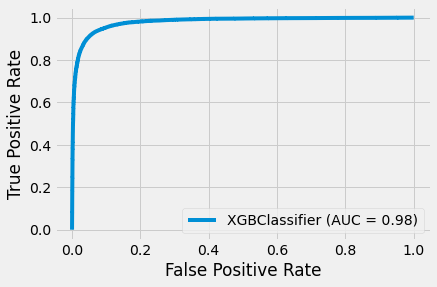

In [118]:
plot_roc_curve(xgb_c, X_test, Y_test)
plt.show()

In [119]:
df_enc.shape

(158392, 68)

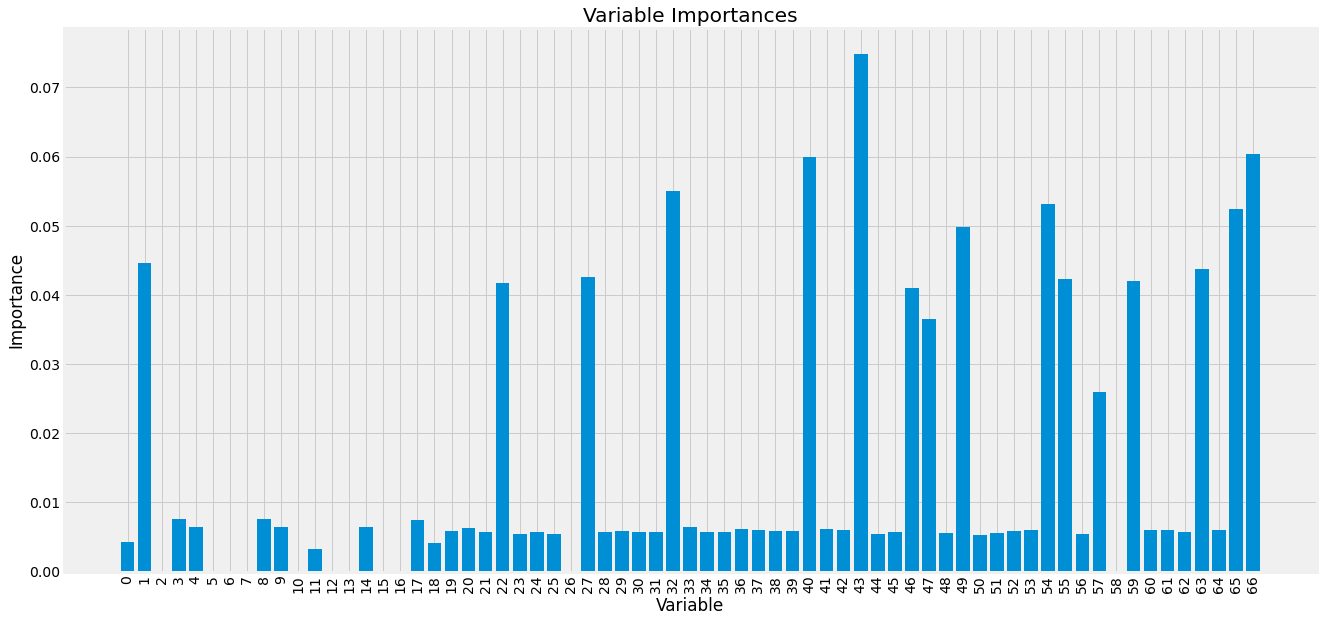

In [120]:
pd_X_train = pd.DataFrame(X_train)
importances = list(xgb_c.feature_importances_)
feature_list = pd_X_train.columns.values.tolist()

%matplotlib inline
# Set the style
plt.figure(figsize=(20,10))

plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [131]:
df_thresh = getThreshold(Y_test,xgb_c.predict_proba(X_test),pos_label=1)
df_thresh

,Threshold,TP,TN,FP,FN,Accuracy,Precision,Recall / Sensitivity,Specificity,F1,FN_Cost,FP_Cost,Tot_Cost,Cost_per_Obs
0,0.00,19026,0,28492,0,0.400396,0.400396,1.000000,0.000000,0.571832,0,284920,284920,5.996044
1,0.02,18929,15823,12669,97,0.731344,0.599057,0.994902,0.455312,0.747827,48500,126690,175190,3.686813
2,0.04,18859,19299,9193,167,0.803022,0.672287,0.991223,0.505766,0.801181,83500,91930,175430,3.691864
3,0.06,18781,21021,7471,245,0.837619,0.715412,0.987123,0.528139,0.829586,122500,74710,197210,4.150217
4,0.08,18733,22101,6391,293,0.859338,0.745622,0.984600,0.541240,0.848607,146500,63910,210410,4.428006
5,0.10,18667,22887,5605,359,0.874490,0.769075,0.981131,0.550777,0.862257,179500,56050,235550,4.957069
6,0.12,18610,23495,4997,416,0.886085,0.788325,0.978135,0.558010,0.873033,208000,49970,257970,5.428890
7,0.14,18549,24022,4470,477,0.895892,0.805813,0.974929,0.564281,0.882340,238500,44700,283200,5.959847
8,0.16,18484,24398,4094,542,0.902437,0.818673,0.971513,0.568957,0.888568,271000,40940,311940,6.564670
9,0.18,18408,24739,3753,618,0.908014,0.830648,0.967518,0.573365,0.893874,309000,37530,346530,7.292605


In [124]:
source = df_thresh
source['opt'] = .45

base = alt.Chart(source)

#red
acc= base.mark_line(color="#fc030f").encode(
    x='Threshold:Q',
    y='Accuracy:Q'
)
#green
prec = base.mark_line(color="#136e1a").encode(
    x='Threshold:Q',
    y='Precision:Q'
)
#blue
rec = base.mark_line(color="#3a3b9c").encode(
    x='Threshold:Q',
    y='Recall / Sensitivity:Q'
)
#orange
spec = base.mark_line(color="#ebac00").encode(
    x='Threshold:Q',
    y='Specificity:Q'
)

optimal = base.mark_rule().encode(
    x='opt'
)
acc+prec+rec+spec+optimal

alt.LayerChart(...)

In [126]:
#.45 threshold has highest precision and accuracy
proba = xgb_c.predict_proba(X_test)
threshold_predict = np.where(proba[:,1] > .45,1,0)
threshold_predict

array([0, 1, 1, ..., 1, 0, 0])

In [127]:
#Compute precision, recall, F-measure and support
print(classification_report(Y_test,threshold_predict))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     28492
           1       0.92      0.92      0.92     19026

    accuracy                           0.93     47518
   macro avg       0.93      0.93      0.93     47518
weighted avg       0.93      0.93      0.93     47518



In [128]:
tn, fp, fn, tp = confusion_matrix(Y_test,threshold_predict).ravel()
print("True Positive: {}".format(tp))
print("False Positive: {}".format(fp))
print("False Negative: {}".format(fn))
print("True Negative: {}".format(tn))
print("=======================")
print("Accuracy: {}".format((tp+tn)/(tp+tn+fp+fn)))
print("TPR: {}".format(tp/(tp+fn)))
print("FPR: {}".format(fp/(fp+tn)))
print("Precision: {}".format(tp/(tp+fp)))

True Positive: 17452
False Positive: 1557
False Negative: 1574
True Negative: 26935
Accuracy: 0.9341091796792794
TPR: 0.9172711027015663
FPR: 0.05464691843324442
Precision: 0.9180914303750854


In [129]:
fp_cost = fp*10
fn_cost = fn*500
print("Cost of False Positives: ${}".format(fp_cost))
print("Cost of False Negatives: ${}".format(fn_cost))
print("Total Cost: ${}".format(fp_cost+fn_cost))

Cost of False Positives: $15570
Cost of False Negatives: $787000
Total Cost: $802570
